SVM - mean accuracies (std) 
 cat (specificity): 0.845833 (0.076942) 
 dog (recall): 0.721154 (0.097964) 
 overall: 0.781000 (0.066776) 

LogReg - mean accuracies (std) 
 cat (specificity): 0.783333 (0.100000) 
 dog (recall): 0.713462 (0.090589) 
 overall: 0.747000 (0.067904) 

RF - mean accuracies (std) 
 cat (specificity): 0.735417 (0.087673) 
 dog (recall): 0.728846 (0.082019) 
 overall: 0.732000 (0.049960) 

About 48.0 percent of mislabels by the SVM is shared by all models.
About 40.0 percent of mislabels by the LogReg is shared by all models.
About 48.0 percent of mislabels by the RF is shared by all models.


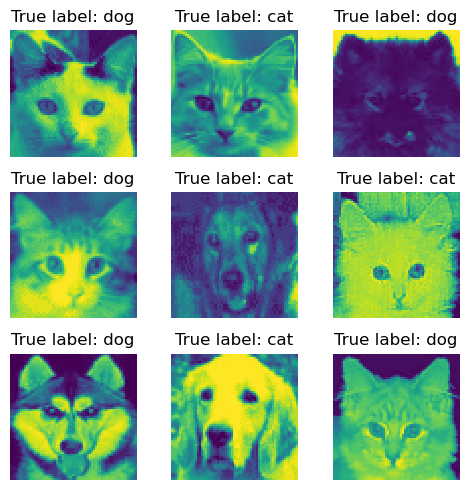

Fraction of missclassified dogs: 0.500000
Fraction of missclassified cats: 0.500000 
(according to algorithm)


In [1]:
import ipynb.fs.full.q1a as q1a

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, SelectKBest, chi2, RFE

def read_data_file(filename: str) -> pd.DataFrame:
    path = Path(os.getcwd() + 'q1b.ipynb')
    data_folder = str(path.parent.absolute()) + '/data/'
    return pd.read_csv(data_folder + filename)


def write_data_file(df: pd.DataFrame, filename: str):
  path = Path(os.getcwd() + 'q1b.ipynb')
  data_folder = str(path.parent.absolute()) + '/data/'
  df.to_csv(data_folder + filename, index=False)


features = read_data_file('CATSnDOGS.csv') / 255
labels = read_data_file('Labels.csv')

models = [
          ('SVM', SVC()),
          ('LogReg', LogisticRegression(max_iter=1000)), 
          ('RF', RandomForestClassifier())
        ]

#tuned_models = q1a.tune_ensemble(models, features, labels)

In [3]:
# Filter method: Variance filtering
def filter_variance(features: pd.DataFrame) -> pd.DataFrame:
    var = np.std(features.to_numpy(), axis=0) ** 2
    var_mean = np.mean(var)
    var_std = np.std(var)
    model = VarianceThreshold(threshold=var_mean+var_std)
    model.fit(features)
    feature_idx = model.get_support(indices=True)
    data = features.iloc[:,feature_idx].copy()
    return data


# Filter method: Chi-squared test
def select_K_best(features: pd.DataFrame, labels: pd.DataFrame, k: int = 200) -> pd.DataFrame:
    model = SelectKBest(score_func=chi2, k=k).fit(features, labels)
    feature_idx = model.get_support(indices=True)
    data = features.iloc[:,feature_idx].copy()
    return data


# Intrinsic method: Lasso regularization
def lasso_sparsfiy(features: pd.DataFrame, labels: pd.DataFrame) -> pd.DataFrame:
    logreg = LogisticRegression(C=200.0, solver='liblinear', penalty="l1", max_iter=5000, dual=False)
    model = SelectFromModel(logreg)
    model.fit(features, labels.to_numpy().ravel())
    feature_idx = model.get_support(indices=True)
    data = features.iloc[:,feature_idx].copy()
    return data


# Wrapper method: Recursive Feature Elimination
def apply_RFE(models: dict, features: pd.DataFrame, labels: pd.DataFrame, n_features_to_select: int):
    models_select = []

    for model in models.values():
        rfe = RFE(model, n_features_to_select=n_features_to_select)
        rfe.fit(features, labels.to_numpy().ravel())
        feature_idx = rfe.support_
        data = features.iloc[:,feature_idx].copy()
        models_select.append(data)

    return models_select
       

def bootstrap_selection_methods(features: pd.DataFrame, labels: pd.DataFrame, iter: int = 50) -> pd.DataFrame:
    data = pd.concat([features.copy(), labels.copy()], axis=1)
    count = np.zeros((3, len(features.columns)))
    
    for it in range(iter):
        sample = data.sample(frac=1.0, replace=True)
        X = sample.iloc[:,0:len(features.columns)]
        y = sample.iloc[:,len(features.columns)]

        filtered = filter_variance(X)
        update_count(count[0], filtered)
        sparsified = lasso_sparsfiy(X, y)
        update_count(count[2], sparsified)
        k = np.maximum(len(filtered.columns),len(sparsified.columns))
        selected = select_K_best(X, y, k=k)
        update_count(count[1], selected)

    freq = count / iter
    return pd.DataFrame(data = freq, columns=features.columns.values)


def bootstrap_RFE(models: dict, features: pd.DataFrame, labels: pd.DataFrame, n_features_to_select: int, iter: int = 50) -> pd.DataFrame:
    data = pd.concat([features.copy(), labels.copy()], axis=1)
    count = np.zeros((3, len(features.columns)))

    for it in range(iter):
        sample = data.sample(frac=1.0, replace=True)
        X = sample.iloc[:,0:len(features.columns)]
        y = sample.iloc[:,len(features.columns)]
        
        models_select = apply_RFE(models, features, labels, n_features_to_select)

        for i, model_select in enumerate(models_select):
            update_count(count[i], model_select)

    freq = count / iter
    return pd.DataFrame(data = freq, columns=features.columns.values)


def update_count(count: np.ndarray, features: pd.DataFrame) ->  np.ndarray:
    feature_names = features.columns.values
    indices = [int(feature.split('V')[1]) for feature in feature_names]
    for i in range(len(indices)):
        count[indices[i]-1] += 1
    
    return count


def get_top_features(features: pd.DataFrame, freq_df: pd.DataFrame, threshold: int) -> pd.DataFrame:
    freq_cpy = freq_df.copy()
    top_features = freq_cpy[freq_cpy > threshold].index.values
    return features.loc[:,top_features].copy()


def plot_feature_frequencies(freq_df: pd.DataFrame, titles: list):
    fig, axes = plt.subplots(1,3)
    for i, ax in enumerate(axes.flatten()):
        indices = np.arange(len(freq_df.columns.values))
        ax.bar(x=indices, height=freq_df.iloc[i,:])
        ax.set_title(titles[i])
        ax.set_ylabel('frequency')
        ax.set_xlabel('feature')
    fig.tight_layout()
    plt.show()


def get_methods_top_features(freq_df: pd.DataFrame, threshold: int) -> list:
    methods_top_features = []
    for i in range(len(freq_df.index)):
        df = get_top_features(features, freq_df.iloc[i,:], threshold=threshold)
        top_features = set(df.columns.values)
        methods_top_features.append(top_features)
    
    return methods_top_features


def plot_top_features(features: pd.DataFrame, labels: pd.DataFrame, freq_df: pd.DataFrame, thresholds: list):
    top_feat_imgs = []

    for threshold in thresholds:
        top_feat_imgs.append(top_feat_to_img_format(freq_df, 0, threshold))
        top_feat_imgs.append(top_feat_to_img_format(freq_df, 1, threshold))
        top_feat_imgs.append(top_feat_to_img_format(freq_df, 2, threshold))

    sample = features.sample(n=1)
    sample_id = sample.index.values[0]
    fig, axes = plt.subplots(3, 3, figsize=(5,5))
    imgs = zip(top_feat_imgs, axes.flatten())
    fig.tight_layout()
    
    for feats, ax in imgs:
        data = sample.to_numpy().reshape(64,64).T
        ax.imshow(data, interpolation='nearest', cmap='gray')
        feats = feats.reshape(64,64).T
        ax.imshow(feats, interpolation='nearest', alpha=0.40)
        ax.axis('off')

        if labels.iat[sample_id,0] == 1:
            ax.set_title('True label: dog.')
        else:
            ax.set_title('True label: cat')
    plt.show()


def top_feat_to_img_format(df: pd.DataFrame, index: int, threshold: int) -> np.ndarray:
    feat = df.iloc[index,:].copy().to_numpy()
    feat[feat > threshold] = 1
    feat[feat <= threshold] = 0
    return feat

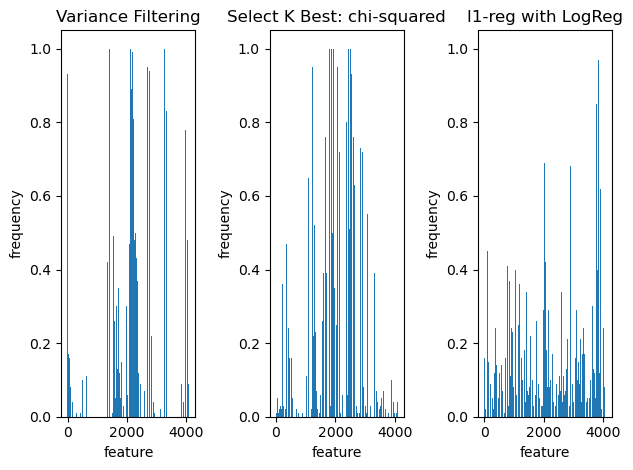

Number of features with frequency > 0.7 for variance filtering: 467 

Number of features with frequency > 0.7 for select K best: 517 

Number of features with frequency > 0.7 for lasso regularization: 144 

Number of features with frequency > 0.7 for shared: 191 



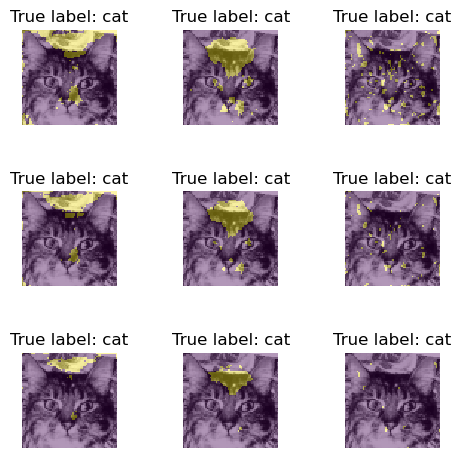

In [4]:
freq_df = bootstrap_selection_methods(features, labels, iter=100)
titles = ['Variance Filtering', 'Select K Best: chi-squared', 'l1-reg with LogReg']
plot_feature_frequencies(freq_df, titles)

threshold = 0.7
methods_top_features = get_methods_top_features(freq_df, threshold)
top_filter = methods_top_features[0]
top_select = methods_top_features[1]
top_sparse = methods_top_features[2]

top_shared = top_filter.intersection(top_select).union(top_filter.intersection(top_sparse)).union(top_select.intersection(top_sparse))

top_feat = {"variance filtering": top_filter, "select K best": top_select, "lasso regularization": top_sparse, "shared": top_shared}
for type, feat in top_feat.items():
    print("Number of features with frequency > %s for %s: %d \n" %(threshold, type, len(feat)))

thresholds = [0.5, 0.7, 0.9]
plot_top_features(features, labels, freq_df, thresholds)

# Variance filtering, features at the edges vary since background color varies
# Select K Best: Sum of normally distributed variables -> chi-squared good? Detects most important features in middle, makes sense
# l1 regularization: How is sparsity viewed in this data?

In [5]:
# SelectKBest seems to work best when viewing the data
top_features_df = get_top_features(features, freq_df.iloc[0,:], threshold=0.5)
write_data_file(top_features_df, 'varfilter_top50_features.csv')

"""
clf_freq_df = bootstrap_RFE(tuned_models, features, labels, n_features_to_select=500, iter=1)

threshold = 0.7
methods_top_features = get_methods_top_features(clf_freq_df, threshold)
top_filter = methods_top_features[0]
top_select = methods_top_features[1]
top_sparse = methods_top_features[2]

top_shared = top_filter.intersection(top_select).union(top_filter.intersection(top_sparse)).union(top_select.intersection(top_sparse))

top_feat = {"variance filtering": top_filter, "select K best": top_select, "lasso regularization": top_sparse, "shared": top_shared}
for type, feat in top_feat.items():
    print("Number of features with frequency > %s for %s: %d \n" %(threshold, type, len(feat)))

thresholds = [0.5, 0.7, 0.9]
plot_top_features(features, labels, freq_df, thresholds)
"""

'\nclf_freq_df = bootstrap_RFE(tuned_models, features, labels, n_features_to_select=500, iter=1)\n\nthreshold = 0.7\nmethods_top_features = get_methods_top_features(clf_freq_df, threshold)\ntop_filter = methods_top_features[0]\ntop_select = methods_top_features[1]\ntop_sparse = methods_top_features[2]\n\ntop_shared = top_filter.intersection(top_select).union(top_filter.intersection(top_sparse)).union(top_select.intersection(top_sparse))\n\ntop_feat = {"variance filtering": top_filter, "select K best": top_select, "lasso regularization": top_sparse, "shared": top_shared}\nfor type, feat in top_feat.items():\n    print("Number of features with frequency > %s for %s: %d \n" %(threshold, type, len(feat)))\n\nthresholds = [0.5, 0.7, 0.9]\nplot_top_features(features, labels, freq_df, thresholds)\n'